In [4]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/disease-symptom-description-dataset/symptom_Description.csv
/kaggle/input/disease-symptom-description-dataset/Symptom-severity.csv
/kaggle/input/disease-symptom-description-dataset/symptom_precaution.csv
/kaggle/input/disease-symptom-description-dataset/dataset.csv
/kaggle/input/symptom-explanation/Symptom explanation.csv


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import networkx as nx

In [6]:
# Load the datasets
symptom_severity_df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/Symptom-severity.csv')
disease_symptom_df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/dataset.csv')
disease_description_df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/symptom_Description.csv')
disease_precaution_df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/symptom_precaution.csv')
symptom_explanation_df = pd.read_csv('/kaggle/input/symptom-explanation/Symptom explanation.csv')

In [7]:
# Incorporate symptom severity
symptom_severity_dict = dict(zip(symptom_severity_df['Symptom'], symptom_severity_df['weight']))

# Create a dictionary to map symptoms to their indices
symptom_to_index = {symptom: index for index, symptom in enumerate(symptom_severity_dict.keys())}

# Remove leading and trailing spaces from disease names in the disease_symptom_df dataset
disease_symptom_df['Disease'] = disease_symptom_df['Disease'].str.strip()
disease_symptom_df = disease_symptom_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Remove leading and trailing spaces from disease names in teh disease_precaution_df dataset
disease_precaution_df['Disease'] = disease_precaution_df['Disease'].str.strip()

# Remove leading and trailing spaces from disease names in the disease_description_df dataset
disease_description_df['Disease'] = disease_description_df['Disease'].str.strip()

disease_symptom_dup = disease_symptom_df.drop_duplicates()

# Function to capitalize words and remove underscores
capitalize_and_remove_underscore = lambda x: x.title().replace('_', '')
disease_precaution_df = disease_precaution_df.fillna('')

In [19]:
symptom_dict = {}
# Iterate over the rows of the dataset
for _, row in symptom_explanation_df.iterrows():
    symptom = row['Symptom']
    explanation = row['Description']

    symptom_dict[symptom] = explanation

In [21]:
# Define symbolic rules
disease_symptom_dict = {}
symptom_disease_dict = {}

# Normalize symptom names
normalize_symptom = lambda symptom: symptom.strip().lower()

# Iterate over the rows of the dataset
for _, row in disease_symptom_dup.iterrows():
    disease = row['Disease']
    symptoms = [normalize_symptom(symptom) for symptom in row.drop('Disease').dropna().tolist()]

    disease_symptom_dict.setdefault(disease, []).extend(symptoms)

    for symptom in symptoms:
        symptom_disease_dict.setdefault(symptom, []).extend(disease)

# Define symbolic rules using a knowledge graph
knowledge_graph = nx.DiGraph()

# Add disease-symptom relationships to the knowledge graph
for _, row in disease_symptom_dup.iterrows():
    disease = row['Disease']
    symptoms = [normalize_symptom(symptom) for symptom in row.drop('Disease').dropna().tolist()]

    knowledge_graph.add_edges_from([(symptom, disease) for symptom in symptoms])

# Custom layer for symbolic reasoning
class SymbolicReasoningLayer(layers.Layer):
    def __init__(self, knowledge_graph, num_diseases, **kwargs):
        super(SymbolicReasoningLayer, self).__init__(**kwargs)
        self.knowledge_graph = knowledge_graph
        self.num_diseases = num_diseases
        self.symbolic_reasoning_output = layers.Dense(self.num_diseases, activation='softmax')

    def call(self, inputs):
        inferred_diseases = []
        for symptoms in inputs:
            inferred_disease = set()
            for symptom in symptoms:
                if symptom in self.knowledge_graph:
                    related_diseases = nx.descendants(self.knowledge_graph, symptom)
                    inferred_disease.update(related_diseases)
            inferred_diseases.append(list(inferred_disease))
        return self.symbolic_reasoning_output(tf.convert_to_tensor(inferred_diseases))

    def explain_prediction(self, patient_symptoms):
        inferred_diseases = []
        for symptoms in patient_symptoms:
            inferred_disease = set()
            for symptom in symptoms:
                if symptom in self.knowledge_graph:
                    related_diseases = nx.descendants(self.knowledge_graph, symptom)
                    inferred_disease.update(related_diseases)
            inferred_diseases.append(list(inferred_disease))
        return inferred_diseases


# Convert patient symptoms to a one-hot encoded vector
def encode_symptoms(symptoms):
    encoded_symptoms = np.zeros(len(symptom_severity_dict))
    for symptom in symptoms:
        if symptom in symptom_to_index:
            encoded_symptoms[symptom_to_index[symptom]] = 1
    return encoded_symptoms

# Create the hybrid model
symptom_input = layers.Input(shape=(len(symptom_severity_dict),), name='symptom_input')

# Neural network component with explainability
neural_network_output = layers.Dense(128, activation='relu')(symptom_input)
neural_network_output = layers.Dropout(0.5)(neural_network_output)
neural_network_output = layers.Dense(64, activation='relu')(neural_network_output)
neural_network_output = layers.Dropout(0.5)(neural_network_output)
neural_network_output = layers.Dense(len(disease_symptom_dict), activation='softmax', name='neural_network_output')(neural_network_output)

# Symbolic reasoning component with explainability
symbolic_reasoning_output = SymbolicReasoningLayer(knowledge_graph, len(disease_symptom_dict))(symptom_input)

# Combine neural network and symbolic reasoning outputs using a multiply layer
combined_output = layers.Multiply(name='combined_output')([neural_network_output, symbolic_reasoning_output])

# Create the hybrid model
model = Model(inputs=[symptom_input], outputs=[combined_output])

# Define optimizer with custom learning rate
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the new optimizer and loss function
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Convert disease-symptom dictionary to training data
X_train = []
y_train = []
for disease, symptoms in disease_symptom_dict.items():
    X_train.append(encode_symptoms(symptoms))
    y_train.append(np.array([1 if d == disease else 0 for d in disease_symptom_dict.keys()]))
X_train = np.array(X_train)
y_train = np.array(y_train)

# Train the model
model.fit(X_train, y_train, epochs=300, batch_size=32)

Epoch 1/300
2/2 [==============================] - 2s 9ms/step - loss: 3.7747 - accuracy: 0.0244
Epoch 2/300
2/2 [==============================] - 0s 9ms/step - loss: 3.7402 - accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 8ms/step - loss: 3.7908 - accuracy: 0.0244
Epoch 4/300
2/2 [==============================] - 0s 7ms/step - loss: 3.6415 - accuracy: 0.0244
Epoch 5/300
2/2 [==============================] - 0s 7ms/step - loss: 3.6870 - accuracy: 0.0488
Epoch 6/300
2/2 [==============================] - 0s 8ms/step - loss: 3.6602 - accuracy: 0.0244
Epoch 7/300
2/2 [==============================] - 0s 7ms/step - loss: 3.6385 - accuracy: 0.0488
Epoch 8/300
2/2 [==============================] - 0s 7ms/step - loss: 3.6520 - accuracy: 0.0488
Epoch 9/300
2/2 [==============================] - 0s 7ms/step - loss: 3.6552 - accuracy: 0.0244
Epoch 10/300
2/2 [==============================] - 0s 7ms/step - loss: 3.6394 - accuracy: 0.0488
Epoch 11/300
2/2 [=======

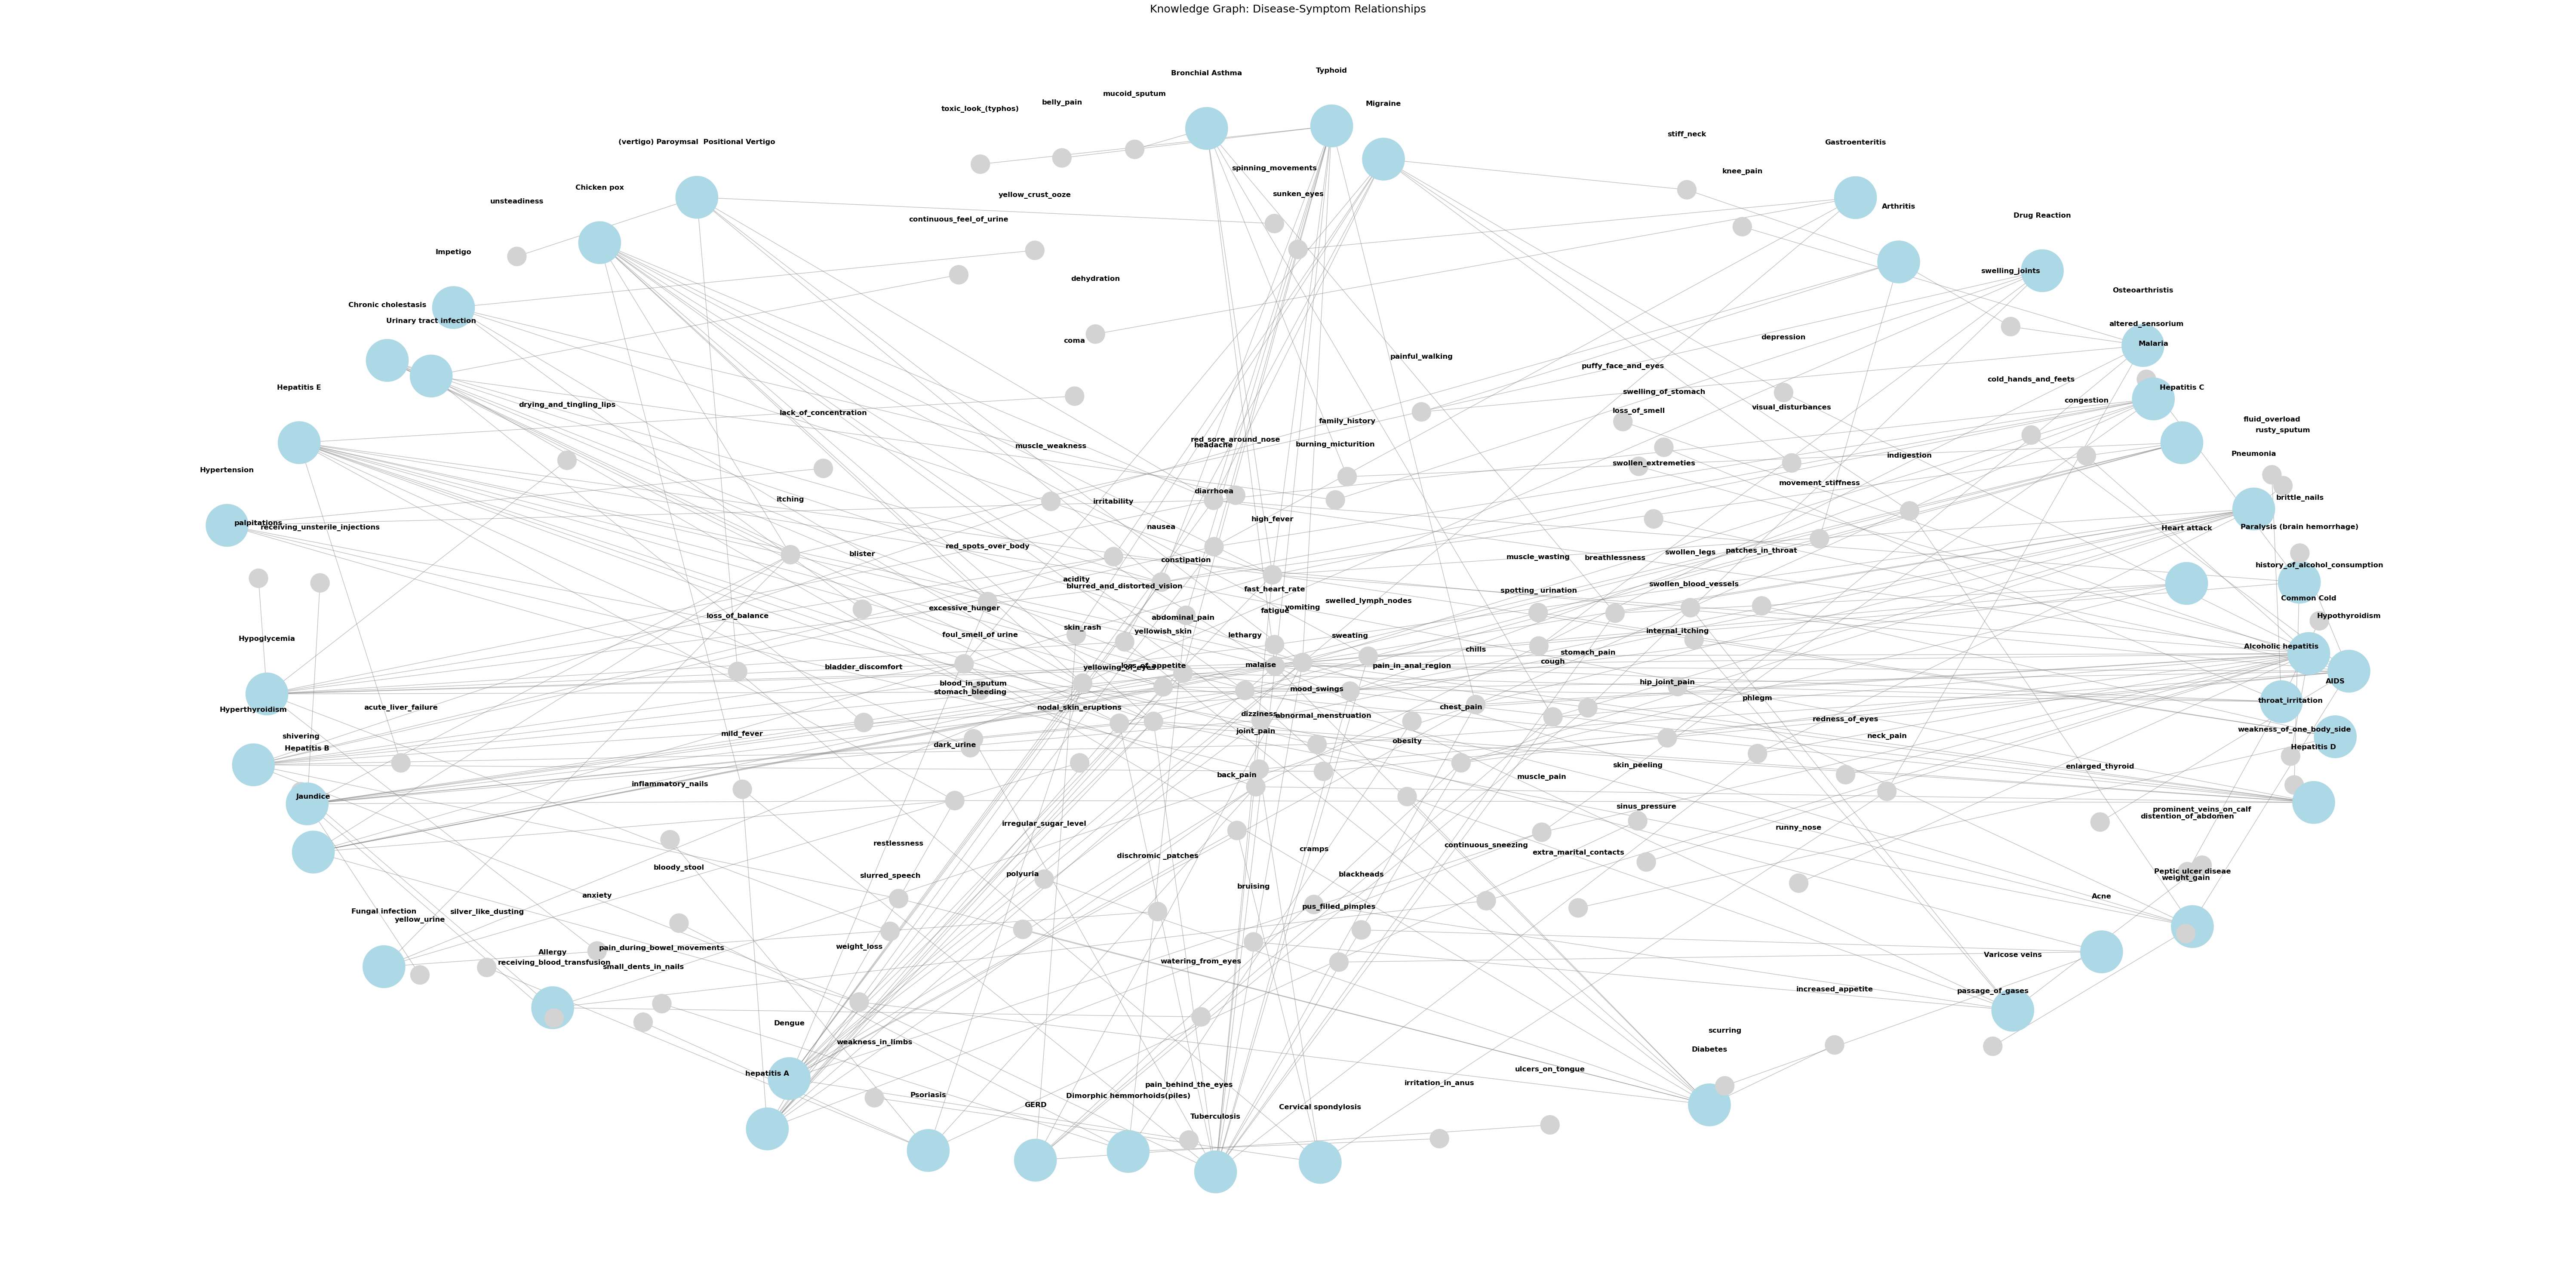

In [22]:
import matplotlib.pyplot as plt

# Separate diseases and symptoms
diseases = set()
symptoms = set()
for node in knowledge_graph.nodes():
    if node in disease_symptom_dict:
        diseases.add(node)
    else:
        symptoms.add(node)

# Define node sizes and colors
node_sizes = [5000 if node in diseases else 1000 for node in knowledge_graph.nodes()]
node_colors = ['lightblue' if node in diseases else 'lightgray' for node in knowledge_graph.nodes()]

# Set up the layout algorithm
pos = nx.spring_layout(knowledge_graph, k=0.7, iterations=100)

# Visualize the knowledge graph
plt.figure(figsize=(60, 30))
nx.draw_networkx_edges(knowledge_graph, pos, alpha=0.5, edge_color='gray')
nx.draw_networkx_nodes(knowledge_graph, pos, node_color=node_colors, node_size=node_sizes)

# Adjust label positions
label_pos = {node: (pos[node][0], pos[node][1] + 0.1) for node in knowledge_graph.nodes()}

nx.draw_networkx_labels(knowledge_graph, label_pos, font_size=12, font_weight='bold', font_color='black')
plt.title("Knowledge Graph: Disease-Symptom Relationships", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
# Function to get feature importance based on model weights
def get_feature_importance(model, user_symptoms):
    feature_names = list(symptom_severity_dict.keys())
    user_symptom_indices = np.array([symptom_to_index[symptom] for symptom in user_symptoms if symptom in symptom_to_index])
    feature_importance = np.abs(model.get_weights()[0]).sum(axis=1)
    user_symptom_importance = feature_importance[user_symptom_indices]
    sorted_indices = np.argsort(user_symptom_importance)[::-1]
    sorted_features = [feature_names[i] for i in user_symptom_indices[sorted_indices]]
    sorted_importance = user_symptom_importance[sorted_indices]
    return sorted_features, sorted_importance


# Function to predict disease based on symptoms using the trained model
def predict_disease(symptoms):
    encoded_symptoms = encode_symptoms(symptoms)
    predicted = model.predict(np.array([encoded_symptoms]))
    disease_index = np.argmax(predicted)
    predicted_disease = list(disease_symptom_dict.keys())[disease_index]

    # Add explanation within the prediction process
    print("The model predicted the disease based on the following symptoms:")
    for symptom in symptoms:
        print("- " + symptom)
    print("The predicted disease is: " + predicted_disease)

    return predicted_disease


def explain_decision(symptoms, user_symptoms):
    encoded_symptoms = encode_symptoms(symptoms)
    predicted = model.predict(np.array([encoded_symptoms]))
    disease_index = np.argmax(predicted)
    predicted_disease = list(disease_symptom_dict.keys())[disease_index]
    top_diseases_indices = np.argsort(predicted)[0][-3:][::-1]
    top_diseases = [list(disease_symptom_dict.keys())[index] for index in top_diseases_indices]
    
    # Get disease description and precautions
    disease_description = get_disease_description(predicted_disease)
    disease_precautions = get_disease_precautions(predicted_disease)
    
    # Check for other diseases with the same symptoms
    potential_diseases = []
    for disease, symptoms in disease_symptom_dict.items():
        if set(user_symptoms).issubset(set(symptoms)):
            potential_diseases.append(disease)
    potential_diseases = set(potential_diseases)
    potential_diseases = list(potential_diseases)
    print("POTENTIAL", potential_diseases)
    
    diseases_same = []
    for disease in potential_diseases:
        dsymptoms = disease_symptom_dict[disease]
        check = all(item in dsymptoms for item in user_symptoms)
        if check is True:
            print()
            diseases_same.append(disease)
            print()
    
    print("TOP", top_diseases)
    for i in top_diseases:
        diseases_same.append(i)
    
    diseases_same = set(diseases_same)
    diseases_same = list(diseases_same)
    count = len(diseases_same)
    
    print()
    print("The predicted disease according to the model is ", predicted_disease)
    print(f"However based on your entered symptoms, there are {count-1} other diseases that can be checked, do you want to check them?")
    print("These are the diseases:")
    for i in diseases_same:
        print(i)
    print()
    
    check = input("Enter yes to check or else proceed with prediction")
    if check == 'yes':
        if(len(potential_diseases)>0):
            for i in potential_diseases:
                print("Checking for disease", i)
                dsd = set(disease_symptom_dict[i])
                us = set(user_symptoms)
                uncommon_symptoms = list(dsd.difference(us))
                for j in uncommon_symptoms[:2]:
                    print("What about this?", j)
                    ans = input("do u have this? (yes or no)")
                    if ans == 'yes':
                        user_symptoms.append(j)
    else:
        print("Okay, proceeding with models prediction without any additional symptoms")
        
    encoded_symptoms = encode_symptoms(user_symptoms)
    predicted = model.predict(np.array([encoded_symptoms]))
    disease_index = np.argmax(predicted)
    predicted_disease = list(disease_symptom_dict.keys())[disease_index]

    # Get disease description and precautions
    disease_description = get_disease_description(predicted_disease)
    disease_precautions = get_disease_precautions(predicted_disease)
    
    # Generate detailed explanation
    explanation = f"Based on the given symptoms, the model predicts the disease as '{predicted_disease}'.\n\n"

    # Feature Importance
    explanation += "Feature Importance:\n"
    features, importance = get_feature_importance(model, user_symptoms)
    explanation += "The most important symptoms for the prediction are:\n"
    for feature, score in zip(features, importance):
        explanation += f"- {feature}: Importance {score}\n"
    explanation += "\n"

    # Neurosymbolic Explanation
    explanation += "Neurosymbolic Explanation:\n"
    explanation += "The model combines neural network predictions and symbolic reasoning to arrive at the disease prediction. "
    explanation += "The neural network analyzes the severity of symptoms and learns patterns from the training data. "
    explanation += "The symbolic reasoning component uses predefined rules and relationships between symptoms and diseases to infer the most likely disease.\n\n"

    # Symptom Analysis
    explanation += "Symptom Analysis:\n"
    explanation += "The model considers the following symptoms and their severities:\n"
    for symptom, severity in symptom_severity_dict.items():
        if symptom in user_symptoms:
            symptom_description = symptom_dict.get(symptom, "Description not available")
            explanation += f"- {symptom}: {symptom_description}. Severity: {severity}\n"
    explanation += "\n"

    # Disease-Symptom Information
    explanation += "Disease-Symptom Information:\n"
    explanation += "The model incorporates information about diseases and their associated symptoms from the dataset.\n"
    explanation += "It learns the relationships between symptoms and diseases through the training process.\n"
    explanation += "\n"
    disease_symptoms = disease_symptom_dict[predicted_disease]


    # Disease Description
    explanation += "Description:\n"
    explanation += f"The predicted disease, '{predicted_disease}', is described as follows:\n"
    explanation += f"{disease_description}\n\n"

    # Precautions
    explanation += "Precautions:\n"
    for i, precaution in enumerate(disease_precautions):
        if (precaution!=""):
            explanation += f"{i + 1}. {precaution}\n"

    return explanation

def get_disease_description(disease):
    description = disease_description_df.loc[disease_description_df['Disease'] == disease, 'Description'].values[0]
    return description

# Function to get disease precautions
def get_disease_precautions(disease):
    precautions = disease_precaution_df.loc[disease_precaution_df['Disease'] == disease].drop('Disease', axis=1).values[0]
    # Apply the function to the numpy array
    precautions = np.vectorize(capitalize_and_remove_underscore)(precautions)
    
    return precautions

# Function to provide rule-based explanations
def get_explanations(symptoms):
    explanations = []
    for disease, symptoms_list in disease_symptom_dict.items():
        symptoms_list = set(symptoms_list)
        if set(symptoms).issubset(symptoms_list):
            explanations.append(f"If {', '.join(symptoms_list)}, then {disease}")
    return explanations

# Triage Categories and their weight ranges
NON_URGENT_CARE = (1, 20)
ROUTINE_CARE = (21, 40)
PRIORITY_CARE = (41, 60)
URGENT_CARE = (61, 80)
IMMEDIATE_ATTENTION = (81, float('inf'))

def calculate_triage_priority(symptoms):
    total_weight = sum(symptom_severity_dict[symptom] for symptom in symptoms)
    if IMMEDIATE_ATTENTION[0] <= total_weight <= IMMEDIATE_ATTENTION[1]:
        return "Immediate Attention"
    elif URGENT_CARE[0] <= total_weight <= URGENT_CARE[1]:
        return "Urgent Care"
    elif PRIORITY_CARE[0] <= total_weight <= PRIORITY_CARE[1]:
        return "Priority Care"
    elif ROUTINE_CARE[0] <= total_weight <= ROUTINE_CARE[1]:
        return "Routine Care"
    elif total_weight >= NON_URGENT_CARE[0]:
        return "Non-Urgent Care"
    else:
        return "Unknown Triage Priority"
    
urgent_care_diseases = [
    'Paralysis (brain hemorrhage)', 'Heart attack', 'Tuberculosis', 'Pneumonia', 'Malaria', 'Dengue', 'Typhoid', 'Hepatitis E'
]

prompt_medical_attention_diseases = [
    'Chronic cholestasis', 'Peptic ulcer disease', 'Jaundice', 'Alcoholic hepatitis', 'Common cold', 'Hypothyroidism',
    'Hyperthyroidism', 'Hypoglycemia', 'Urinary tract infection'
]

non_urgent_care_diseases = [
    'Fungal infection', 'Allergy', 'GERD', 'Drug Reaction', 'Gastroenteritis', 'Bronchial Asthma', 'Migraine', 
    'Cervical spondylosis', 'Varicose veins', 'Osteoarthristis', 'Arthritis', '(vertigo) Paroymsal  Positional Vertigo', 
    'Acne', 'Psoriasis', 'Impetigo'
]

def classify_disease(disease):
    if disease in urgent_care_diseases:
        return 'Urgent Care'
    elif disease in prompt_medical_attention_diseases:
        return 'Prompt Medical Attention'
    elif disease in non_urgent_care_diseases:
        return 'Non-Urgent Care'
    else:
        return 'Unclassified'
    
def provide_verdict(symptoms,predicted_disease):
    triage_priority = calculate_triage_priority(symptoms)
    disease_classification = classify_disease(predicted_disease)

    if triage_priority == "Immediate Attention" or disease_classification == "Urgent Care":
        importance = "High Importance"
    elif triage_priority == "Urgent Care" or disease_classification == "Prompt Medical Attention":
        importance = "Medium Importance"
    elif triage_priority == "Priority Care" or disease_classification == "Non-Urgent Care":
        importance = "Low Importance"
    else:
        importance = "Unknown Importance"

    return f"Verdict: Triage Priority - {triage_priority}, Disease Classification - {disease_classification}, Importance - {importance}"

In [24]:
# Example usage
patient_symptoms = ['vomiting','breathlessness', 'sweating', 'chest_pain']
triage_priority = calculate_triage_priority(patient_symptoms)
predicted_disease = predict_disease(patient_symptoms)
explanation = explain_decision(patient_symptoms, patient_symptoms)
explanations = get_explanations(patient_symptoms)

# Print the explanations
if explanations:
    print("Rule based explanations based on entered symptoms:")
    for expln in explanations:
        print(f"- {expln}")
else:
    print("No rule based explanations found for the given symptoms.\n")

print('\nPatient Symptoms:')
for symptom in patient_symptoms:
    print(symptom)
print('\nPredicted Disease:\n', predicted_disease)

print("\n",provide_verdict(patient_symptoms,predicted_disease))
print('\nExplanation:\n', explanation)

1/1 [==============================] - 0s 116ms/step
The model predicted the disease based on the following symptoms:
- vomiting
- breathlessness
- sweating
- chest_pain
The predicted disease is: Heart attack
1/1 [==============================] - 0s 21ms/step
POTENTIAL ['Heart attack', 'Tuberculosis']




TOP ['Heart attack', 'Tuberculosis', 'Pneumonia']

The predicted disease according to the model is  Heart attack
However based on your entered symptoms, there are 2 other diseases that can be checked, do you want to check them?
These are the diseases:
Heart attack
Tuberculosis
Pneumonia



Enter yes to check or else proceed with prediction No


Okay, proceeding with models prediction without any additional symptoms
1/1 [==============================] - 0s 19ms/step
Rule based explanations based on entered symptoms:
- If vomiting, sweating, high_fever, chest_pain, blood_in_sputum, malaise, breathlessness, yellowing_of_eyes, weight_loss, loss_of_appetite, phlegm, chills, mild_fever, swelled_lymph_nodes, fatigue, cough, then Tuberculosis
- If chest_pain, sweating, vomiting, breathlessness, then Heart attack

Patient Symptoms:
vomiting
breathlessness
sweating
chest_pain

Predicted Disease:
 Heart attack

 Verdict: Triage Priority - Non-Urgent Care, Disease Classification - Urgent Care, Importance - High Importance

Explanation:
 Based on the given symptoms, the model predicts the disease as 'Heart attack'.

Feature Importance:
The most important symptoms for the prediction are:
- chest_pain: Importance 13.745162963867188
- breathlessness: Importance 13.683256149291992
- sweating: Importance 12.928014755249023
- vomiting: Importa